# PTEN loss Survival Analysis for OV

Imports

In [61]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [62]:
'''
Params
cancer_object: Object. The loaded cancer data set.
all_prot: List. trans proteins used to get proteomics data. 
gene_in: String. Gene used to get mutation status for the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with trans proteomics and mutation status of a specific gene.
'''

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN', utils = ut):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor')
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
            prot_and_mutations = rename_duplicate_cols(prot_and_mutations)
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot, tissue_type = 'tumor')
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = rename_duplicate_cols(omics)
        omics = omics.drop(columns='PTEN_CNV')
       
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [63]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

# Step 1: Import data

In [2]:
ov = cptac.Ovarian()
clinical = ov.get_clinical()
proteomics = ov.get_proteomics()
follow_up = ov.get_followup()

# Step 2: Get df with PTEN mutation status and clinical data

In [141]:
# use the function all_prot_format_df to get a df with a Mutation col with
# PTEN deletion / wt samples
del_wt = all_prot_format_df(ov, ['PTEN'])

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 98 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 01OV029, 02OV015 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, 

In [181]:
# Join clinical and pten del_wt keeping samples with pten del or wt tumors
clinical_and_protein = del_wt.join(clinical, how = 'left')
omics_genes = ['PTEN']
clinical_and_protein

Name,PTEN,Mutation,Sample_Tumor_Normal,Participant_Procurement_Age,Participant_Gender,Participant_Race,Participant_Ethnicity,Participant_Jewish_Heritage,Participant_History_Malignancy,Participant_History_Chemotherapy,...,New_Tumor_Event_Site,Other_New_Tumor_Event_Site,Days_Between_Collection_And_New_Tumor_Event,New_Tumor_Event_Diagnosis,New_Tumor_Event_Surgery,Days_Between_Collection_And_New_Tumor_Event_Surgery,New_Tumor_Event_Chemotherapy,New_Tumor_Event_Immunotherapy,New_Tumor_Event_Hormone_Therapy,New_Tumor_Event_Targeted_Molecular_Therapy
Patient_ID,,,,,,,,,,,,,,,,,,,,,
01OV007,0.509384,Wildtype_Tumor,Tumor,820.0,Female,White,Not Hispanic or Latino,Unknown,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01OV017,-0.425281,Deletion,Tumor,672.0,Female,White,Not Hispanic or Latino,Not Jewish,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01OV018,0.683198,Wildtype_Tumor,Tumor,535.0,Female,White,Not Hispanic or Latino,Not Jewish,No,No,...,Other (specify),"Vaginal cuff, right hepatorenal recess, liver,...",325.0,Convincing imaging,No,NaN,Yes,No,No,No
01OV023,0.062758,Deletion,Tumor,707.0,Female,White,Not Hispanic or Latino,Not Jewish,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01OV026,0.560112,Wildtype_Tumor,Tumor,932.0,Female,White,Not Hispanic or Latino,Not Jewish,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26OV002,-0.848095,Deletion,Tumor,695.0,Female,White,Not Hispanic or Latino,Unknown,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26OV008,0.279188,Wildtype_Tumor,Tumor,782.0,Female,White,Not Evaluated,Not Jewish,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26OV009,-0.608438,Wildtype_Tumor,Tumor,728.0,Female,White,Unknown,Not Jewish,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
clin_prot_follow = pd.merge(clinical_and_protein, follow_up, on = "Patient_ID")

#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['Vital_Status',
                       'Days_Between_Collection_And_Last_Contact', 
                       'Days_Between_Collection_And_Death']

focus_group = clin_prot_follow[columns_to_focus_on].copy().drop_duplicates()

# Join clinical focus cols with mutation status df  
focus_group = del_wt.join(focus_group)
focus_group

Name,PTEN,Mutation,Vital_Status,Days_Between_Collection_And_Last_Contact,Days_Between_Collection_And_Death
Patient_ID,,,,,
01OV007,0.509384,Wildtype_Tumor,Living,368.0,NaN
01OV017,-0.425281,Deletion,Living,395.0,NaN
01OV018,0.683198,Wildtype_Tumor,Living,390.0,NaN
01OV023,0.062758,Deletion,Living,375.0,NaN
01OV026,0.560112,Wildtype_Tumor,Deceased,NaN,112.0
...,...,...,...,...,...
26OV002,-0.848095,Deletion,Living,330.0,NaN
26OV008,0.279188,Wildtype_Tumor,Deceased,NaN,399.0
26OV009,-0.608438,Wildtype_Tumor,Living,726.0,NaN


# Step 3: Kaplan Meier Plotting

Kaplan Meier plots show the probability of some event occuring over a given length of time, based on some attribute(s). 

In [183]:
#Make the Vital Status column boolean
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Living', False)
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Deceased', True)
focus_group['Vital_Status'] = focus_group['Vital_Status'].astype('bool')

In [184]:
# Create one column with days between last contact or death
cols = ['Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']

focus_group = focus_group.assign(Days_Until_Last_Contact_Or_Death=focus_group[cols].sum(1)).drop(cols, 1)
focus_group

Name,PTEN,Mutation,Vital_Status,Days_Until_Last_Contact_Or_Death
Patient_ID,,,,
01OV007,0.509384,Wildtype_Tumor,False,368.0
01OV017,-0.425281,Deletion,False,395.0
01OV018,0.683198,Wildtype_Tumor,False,390.0
01OV023,0.062758,Deletion,False,375.0
01OV026,0.560112,Wildtype_Tumor,True,112.0
...,...,...,...,...
26OV002,-0.848095,Deletion,False,330.0
26OV008,0.279188,Wildtype_Tumor,True,399.0
26OV009,-0.608438,Wildtype_Tumor,False,726.0


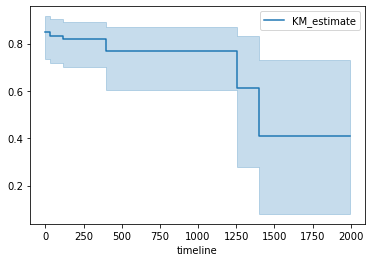

In [185]:
# Plot
time = focus_group['Days_Until_Last_Contact_Or_Death']
status = focus_group['Vital_Status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test

In [186]:
df_genes = focus_group.copy()
df_genes.head()

Name,PTEN,Mutation,Vital_Status,Days_Until_Last_Contact_Or_Death
Patient_ID,,,,
01OV007,0.509384,Wildtype_Tumor,False,368.0
01OV017,-0.425281,Deletion,False,395.0
01OV018,0.683198,Wildtype_Tumor,False,390.0
01OV023,0.062758,Deletion,False,375.0
01OV026,0.560112,Wildtype_Tumor,True,112.0


In [187]:
# map numeric values to correspond with mutation status
mutation_map = {"Wildtype_Tumor" : 1, "Deletion" : 2} 

df_genes['PTEN'] = df_genes['Mutation'].map(mutation_map)
df_genes.head()

Name,PTEN,Mutation,Vital_Status,Days_Until_Last_Contact_Or_Death
Patient_ID,,,,
01OV007,1,Wildtype_Tumor,False,368.0
01OV017,2,Deletion,False,395.0
01OV018,1,Wildtype_Tumor,False,390.0
01OV023,2,Deletion,False,375.0
01OV026,1,Wildtype_Tumor,True,112.0


In [195]:
df_genes.PTEN.value_counts()

1    46
2    20
Name: PTEN, dtype: int64

In [188]:
#Then we will drop missing values, as missing values 
#will throw an error in the functions we will use in lifelines.
df_clean = df_genes.dropna(axis=0, how='any').copy()
len(df_clean)

66

Verify that your columns are the correct data types.  The event of interest, in this case Vital_Status needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [191]:
df_clean = df_clean.drop(columns= 'Mutation') # drop col with str values (info mapped to PTEN as int)

for col in df_clean.columns:
    print(col, ":", df_clean[col].dtype)

PTEN : int64
Vital_Status : bool
Days_Until_Last_Contact_Or_Death : float64


# Step 5: Plot Multivariate Survival Risk

In [196]:
cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "Days_Until_Last_Contact_Or_Death", 
        event_col = "Vital_Status")

<lifelines.CoxPHFitter: fitted with 66 total observations, 51 right-censored observations>

In [193]:
attributes = ['PTEN']

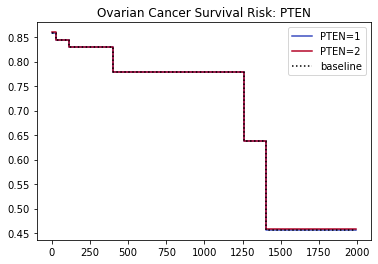

In [199]:
for attribute in attributes:
    plot_title = "Ovarian Cancer Survival Risk: " + attribute
    cph.plot_partial_effects_on_outcome(attribute, [1,2], cmap='coolwarm', title=plot_title)


In [174]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 59 total observations, 54 right-censored observations>
             duration col = 'Days_Until_Last_Contact_Or_Death'
                event col = 'Vital_Status'
      baseline estimation = breslow
   number of observations = 59
number of events observed = 5
   partial log-likelihood = -13.508
         time fit was run = 2020-10-02 16:36:47 UTC
                    model = untransformed variables

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
PTEN                    0.274      1.315      1.217           -2.112            2.660                0.121               14.301
Tumor_Stage_Ovary_FIGO -0.646      0.524      1.173           -2.944            1.653                0.053                5.221

                            z     p   -log2(p)
covariate                                     
PTEN                    0.225 0.822      0.283
Tumor_Stage_Ovary_FIGO -0.551 0.582      0.781
---
Concordance = 0.642
Partial AIC = 31.016
log-likelihood ratio test = 0.343 on 2 df
-log2(p) of ll-ratio test = 0.247

# Step 6: Cox's Proportional Hazard Test

In [175]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 59 total observations, 54 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic    p  -log2(p)
PTEN                              0.89 0.34      1.54
Tumor_Stage_Ovary_FIGO            0.00 0.98      0.02

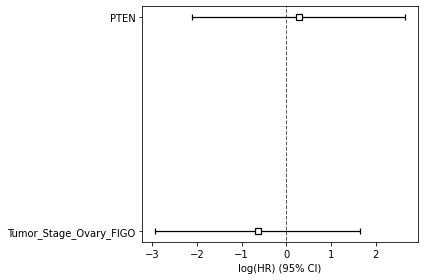

In [176]:

cph.plot()
plt.tight_layout()